# To model the low level image processing tasks in the framework of Markov Random Field and Conditional Random Field. To understand the working of Hopfield network and use it for solving some interesting combinatorial problems

## Imports

In [ ]:
import numpy as np
from skimage import data, io, filters
from matplotlib import pyplot as plt
from PIL import Image
from skimage.transform import resize
import random
%matplotlib inline

## Part A

### Converting the image to binary

Dimensions of the image are: (512, 512)


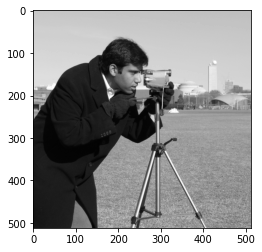

In [ ]:
# Load an image of a cameraman
cameraman = data.camera()

# Dimensions of image
print("Dimensions of the image are:", cameraman.shape)

# Display image
plt.imshow(cameraman, cmap='gray')

In [ ]:
def binarize_img(im):
    '''
    Converts an image to it's binary form
    
    Arguments
    im: An nd-array of the image

    Returns
    bin_im: Binarized form of the image
    '''
    
    # Normalize the image
    bin_im = im / 255.
    
    # Allow the array to be modified
    bin_im.flags.writeable = True
    
    # Set pixel values
    bin_im[bin_im < 0.5] = 0
    bin_im[bin_im >= 0.5] = 1

    return bin_im

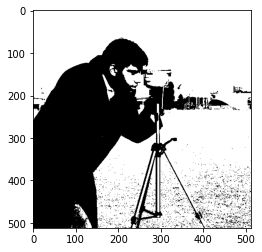

In [ ]:
bin_cameraman = binarize_img(cameraman)
plt.imshow(bin_cameraman, cmap='gray')

### Adding Noise

In [ ]:
def add_noise(orig_img, thresh=0.05):
    '''
    Adds random noise to an image
    
    Arguments
    orig_img: An nd-array of the original image
    thresh: The noise threshold (default: 0.05)

    Returns
    noisy_img: The noisy version of the original image
    '''
    
    N, M = orig_img.shape
    noisy_img = orig_img.copy()
    
    # Generate random noise with the same dimensions as the original image
    noise = np.random.rand(N, M)
    
    # Thresholding the noise
    noise[noise < 1-thresh] = 0
    noise[noise >= 1-thresh] = 1
    
    # Taking modulo to keep result values in range
    noisy_img = (noisy_img + noise) % 2
    
    return noisy_img

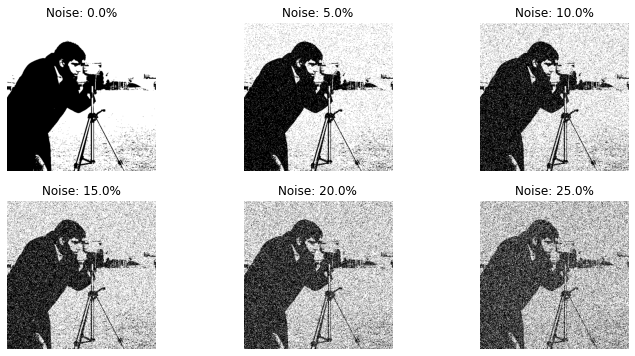

In [ ]:
fig = plt.figure(figsize=(12, 6))
for i in range(0, 5 + 1): 
    # Set the noise threshold and generate a noisy image
    thresh = i/20
    noisy_img = add_noise(bin_cameraman, thresh)
    
    plt.subplot(2, 3, i+1)
    plt.title(f'Noise: {thresh*100}%')
    plt.axis('off')
    
    plt.imshow(noisy_img, cmap='gray')
plt.show()

### Denoising the image

In [ ]:
def get_neighbours(i, j, M, N):
    neighbours = []
    if i > 0:
        neighbours.append([i-1, j])
    if i < M-1:
        neighbours.append([i+1, j])
    if j > 0:
        neighbours.append([i, j-1])
    if j < N-1:
        neighbours.append([i, j+1])

    return neighbours

In [ ]:
def enrg(new, old, y, neighbours):
    # Set the value of the regularization parameter lambda to -100
    lmda = -100
    '''
    Calculate the energy of the proposed new pixel value using the formula:
    (new - old)^2 + lambda * sum((new - y[n[0], n[1]])^2 for n in neighbours)
    where:
    - `new` is the proposed new pixel value
    - `old` is the original pixel value
    - `y` is the original noisy image
    '''
    return (new - old)**2 + lmda * np.sum((new - y[neighbour[0], neighbour[1]])**2 for neighbour in neighbours)

In [ ]:
def diff(y, y_old):
    # Calculate absolute difference between the two images, and divide by 2 to get a binary image
    diff = abs(y - y_old) / 2
    
    # Calculate percentage of pixels that have changed between the two images,
    # by summing the binary image and dividing by the total number of pixels in the image.
    return (100.0 * np.sum(diff)) / np.size(y)

In [ ]:
def denoise(noisy_img):
    M, N = noisy_img.shape
    y = noisy_img.copy()
    maxiter = 5*M*N

    for iter in range(maxiter):
        i = np.random.randint(M)
        j = np.random.randint(N)
        neighbours = get_neighbours(i, j, M, N)

        enrg_1 = enrg(1, y[i, j], y, neighbours)
        enrg_0 = enrg(0, y[i, j], y, neighbours)

        if enrg_1 > enrg_0:
            y[i, j] = 1
        else:
            y[i, j] = 0
        
        if iter % 100000 == 0:
            print (f'Completed {iter} iterations out of {maxiter}. Denoized pixels are: {diff(y, noisy_img)}%')

    return y

## Testing

Denoising for noise level: 5.0
Completed 0 iterations out of 1310720. Denoized pixels are: 0.0%


<ipython-input-8-b4098c985e50>:12: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return (new - old)**2 + lmda * np.sum((new - y[neighbour[0], neighbour[1]])**2 for neighbour in neighbours)


Completed 100000 iterations out of 1310720. Denoized pixels are: 1.4486312866210938%
Completed 200000 iterations out of 1310720. Denoized pixels are: 2.3189544677734375%
Completed 300000 iterations out of 1310720. Denoized pixels are: 2.823638916015625%
Completed 400000 iterations out of 1310720. Denoized pixels are: 3.145599365234375%
Completed 500000 iterations out of 1310720. Denoized pixels are: 3.369903564453125%
Completed 600000 iterations out of 1310720. Denoized pixels are: 3.5243988037109375%
Completed 700000 iterations out of 1310720. Denoized pixels are: 3.6291122436523438%
Completed 800000 iterations out of 1310720. Denoized pixels are: 3.7075042724609375%
Completed 900000 iterations out of 1310720. Denoized pixels are: 3.7683486938476562%
Completed 1000000 iterations out of 1310720. Denoized pixels are: 3.814697265625%
Completed 1100000 iterations out of 1310720. Denoized pixels are: 3.8557052612304688%
Completed 1200000 iterations out of 1310720. Denoized pixels are: 3.89

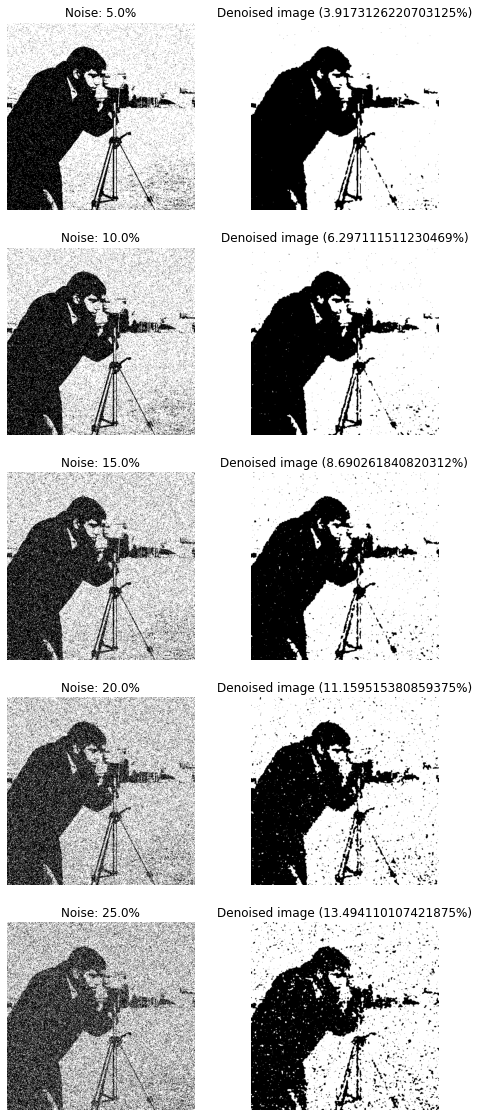

In [ ]:
fig = plt.figure(figsize=(8, 20))

for i in range(1, 5 + 1):
    thresh = i/20
    print(f"Denoising for noise level: {thresh*100}")

    noisy_img = add_noise(bin_cameraman, thresh)
    denoised_img = denoise(noisy_img)

    plt.subplot(5, 2, 2*i-1)
    plt.title(f'Noise: {thresh*100}%')
    plt.axis('off')
    plt.imshow(noisy_img, cmap='gray')

    plt.subplot(5, 2, 2*i)
    plt.title(f'Denoised image ({diff(noisy_img, denoised_img)}%)')
    plt.axis('off')
    plt.imshow(denoised_img, cmap='gray')

    print()
plt.show()